# COM6509 Assignment1

## 1. Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

### a. Deal with missing data
Columns that contain more than 15% '?' will be dropped. Others '?' and NaN data will be replaced by the mode of each column. And those modes will be recorded in a dictionary.

In [2]:
train_set = pd.read_csv("train.csv")
(row, col) = train_set.shape
attributes = train_set.columns.values.tolist()

col_drop = [] 
for c in range(col):
    attribute = attributes[c]
    count = (train_set[attribute] == "?").sum()
    perc = count/row
    if perc > 0.15:
        col_drop.append(attribute)
    #print(attribute, perc)
print(col_drop) # Attributes which should be dropped

['Cat2', 'Cat4', 'Cat5', 'Cat7']


In [3]:
miss_value_dic = {}
for c in range(col):
    miss_data = train_set[attributes[c]].mode()
    miss_value_dic[c] = miss_data[0]
    train_set[attributes[c]].fillna(miss_data[0], inplace=True)
    train_set[attributes[c]].replace('?', miss_data[0],inplace=True)

### b. Choose categorical variables
Histogram and correlation matrix will be used to determine which data can be used to train models.

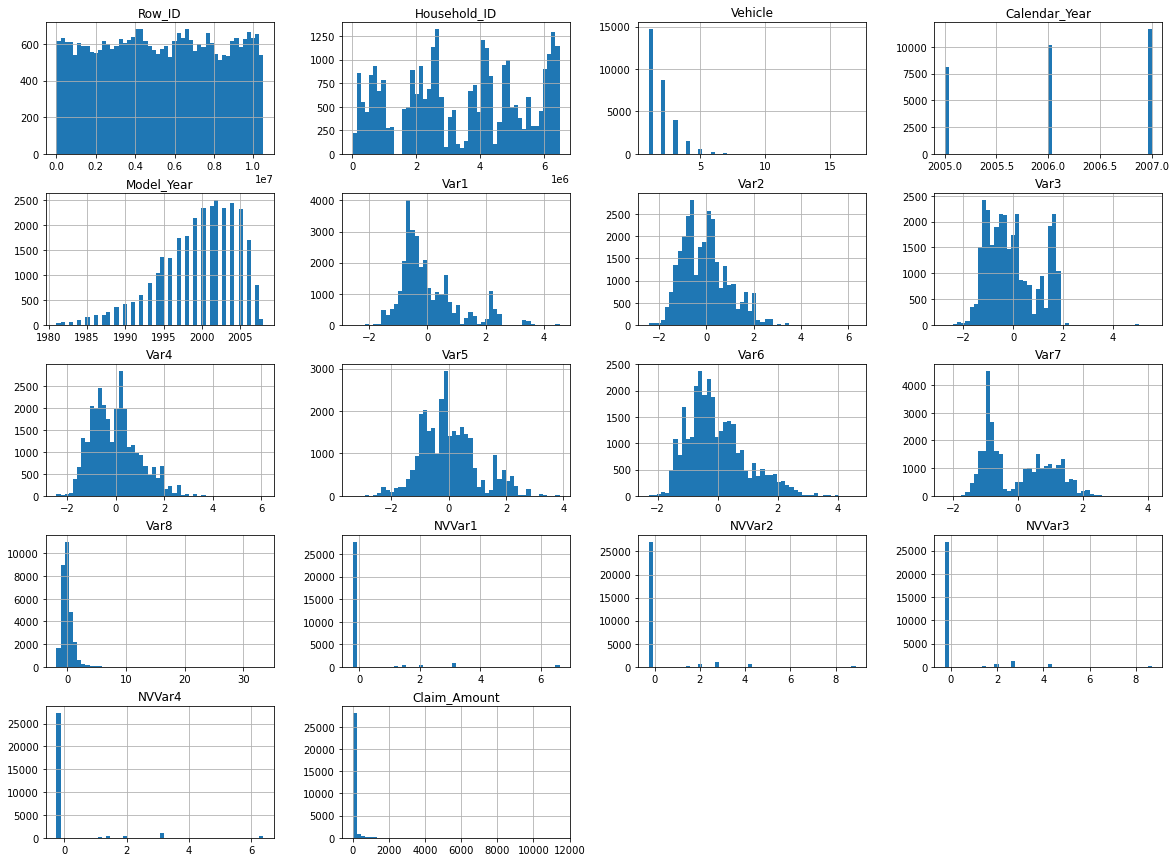

In [4]:
train_set[attributes].hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

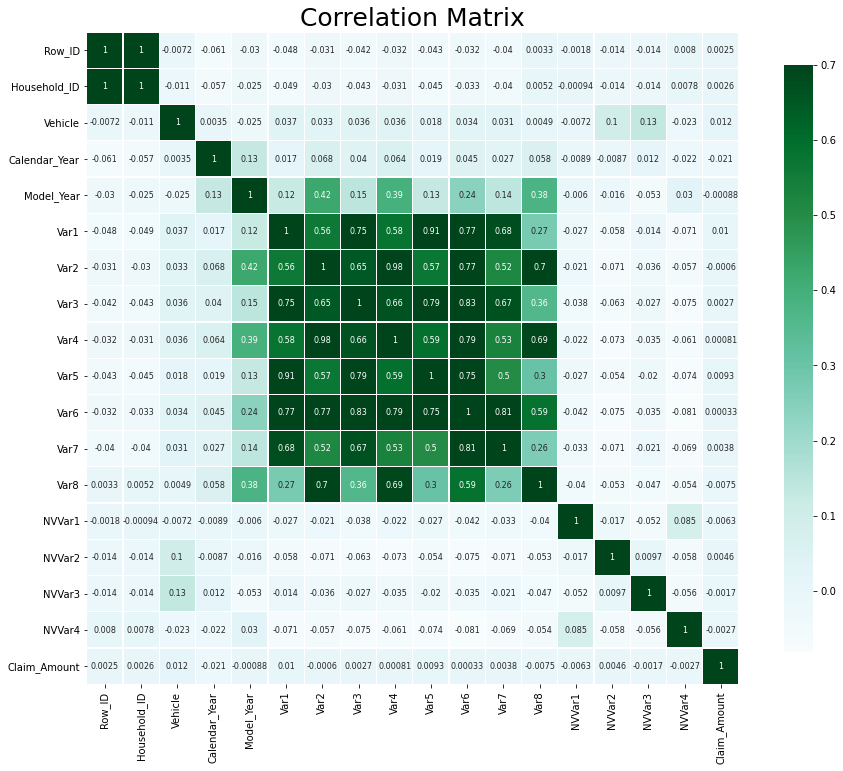

In [5]:
plt.subplots(figsize=(16,12))
plt.title('Correlation Matrix',fontsize=25)
correlation_mat = train_set[attributes].corr()
sns.heatmap(correlation_mat, linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},cbar_kws={"shrink": .9})

From the correlation matrxi, it is easily to find that ['Var2, Var4'], ['Var1, Var5'], ['Var3, Var6'], [Var6, Var7] have high Correlation coefficient which are bigger than 0.8. Var1, Var4, Var6 will be dropped.

Some catalogues which have too many kinds of variables should also be dropped.

In [6]:
need_drop = ['Row_ID', 'Household_ID', 'Var1', 'Var4', 'Var6', 'Blind_Make',
             'Blind_Model', 'Blind_Submodel','Cat2', 'Cat4', 'Cat5', 'Cat7', 'OrdCat']
train_set = train_set.drop(need_drop ,axis = 1)
for col in [ 'Vehicle', 'Calendar_Year', 'Model_Year']:
    train_set[col] = train_set[col].astype('float64')

### c. Deal with highly imbalance data
The date is highly imbalanced, there has 70% '0' in the column 'Claim_Amount', we choose to copy those data which 'Claim_Amount' are not equal to '0'. To avoid train set and validation set have the same data, the dataset will be split first, then, data in train_set will be copied to achieve data balanced.

In [7]:
from sklearn.model_selection import train_test_split
cp_train_set1, cp_val_set1 = train_test_split(train_set, test_size=0.15, random_state=8)

In [8]:
copy1 = cp_train_set1[cp_train_set1['Claim_Amount']!=0]
lenth = len(cp_train_set1)-2*len(copy1)
copy2 = copy1[0:lenth]
cp_train_set1 = cp_train_set1.append(copy2)

## 2. Performance using a single model

In this part, train_set will be split to attributes and labels, which can be understood as x and y. Y presentive data in 'Claim_Amount'.

Root mean square error will be used to measure the performance of each model.

As required, grid search part will be comment.

In [9]:
cp_train_set1_attributes = cp_train_set1.drop('Claim_Amount', axis=1)
cp_train_set1_labels = cp_train_set1['Claim_Amount']

cp_val_set1_attributes = cp_val_set1.drop('Claim_Amount', axis=1)
cp_val_set1_labels = cp_val_set1['Claim_Amount']

In [10]:
attributes_cat = list(cp_train_set1_attributes.select_dtypes(include=['object']))
attributes_num = list(cp_train_set1_attributes.select_dtypes(include=['float64']))

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

full_transform = ColumnTransformer([
    ("num", StandardScaler(), attributes_num),
    ("cat", OneHotEncoder(), attributes_cat),
])

In [12]:
cp_train_set1_attributes_prepared = full_transform.fit_transform(cp_train_set1_attributes)
cp_val_set1_attributes_prepared = full_transform.transform(cp_val_set1_attributes)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### a. Linera regression

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
cp_val_set1_predictions_lin = lin_reg.predict(cp_val_set1_attributes_prepared)
error_lin = np.sqrt(mean_squared_error(cp_val_set1_labels, cp_val_set1_predictions_lin))
print('error_lin :', error_lin)

error_lin : 212.5318142745481


In [15]:
'''
parameters_lin = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False]}
grid_linreg = GridSearchCV(lin_reg, parameters_lin, verbose=1 , scoring = "r2",n_jobs = -1)
grid_linreg.fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
'''
grid_linreg = LinearRegression(copy_X=True, fit_intercept=True,normalize=False).fit(cp_train_set1_attributes_prepared, 
                                                                                    cp_train_set1_labels)
y_pred = grid_linreg.predict(cp_val_set1_attributes_prepared)
error_gridLin = np.sqrt(mean_squared_error(cp_val_set1_labels, y_pred))
error_gridLin

212.5318142745481

### b. Ridge regression

In [16]:
ridge = Ridge().fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
cp_val_set1_Ridge = ridge.predict(cp_val_set1_attributes_prepared)
error_Ridge = np.sqrt(mean_squared_error(cp_val_set1_labels, cp_val_set1_Ridge))
print('error_Rridge', error_Ridge)

error_Rridge 212.49561052294118


In [17]:
'''
parameters_ridge = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False], "solver" : ["auto"]}
grid_ridge = GridSearchCV(ridge, parameters_ridge, verbose=1, scoring="r2", n_jobs = -1)
grid_ridge.fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
print("Best  Model: " + str(grid_ridge.best_estimator_))
'''
grid_ridge = Ridge(fit_intercept=False, normalize=True).fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
y_pred = grid_ridge.predict(cp_val_set1_attributes_prepared)
error_gridRidge = np.sqrt(mean_squared_error(cp_val_set1_labels, y_pred))
print('error_gridRidge :', error_gridRidge)

error_gridRidge : 212.49531259388598


### c. Random forest for regression

In [18]:
RFR = RandomForestRegressor(n_estimators = 10, random_state = 0, n_jobs = -1)
RFR.fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
cp_val_set1_RFR = RFR.predict(cp_val_set1_attributes_prepared)
error_RFR= np.sqrt(mean_squared_error(cp_val_set1_labels, cp_val_set1_RFR))
print('error_RFR : ',error_RFR)

error_RFR :  272.3218520455163


In [19]:
'''
param_test = param_grid = [
 {'n_estimators': [10, 50, 100], 'max_features': [1, 2, 4], 'max_depth' :[50, 100, 150], 'n_jobs' : [-1]}
 ]
gridRFR = GridSearchCV(RFR,
   param_grid = param_test, scoring='neg_mean_squared_error',return_train_score=True, cv=5)
gridRFR.fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
print("Best  Model: " + str(gridRFR.best_estimator_))
'''

gridRFR = RandomForestRegressor(max_depth=50, max_features=2, n_jobs=-1, random_state=0).fit(cp_train_set1_attributes_prepared,
                                                                                             cp_train_set1_labels)
cp_val_set1_gridRFR = gridRFR.predict(cp_val_set1_attributes_prepared)
error_gridRFR= np.sqrt(mean_squared_error(cp_val_set1_labels, cp_val_set1_gridRFR))
print('error_gridRFR : ', error_gridRFR)

error_gridRFR :  228.35469447757313


### d. Gradient tree boosting for regression

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
cp_val_set1_gbr = gbr.predict(cp_val_set1_attributes_prepared)
error_gbr = np.sqrt(mean_squared_error(cp_val_set1_labels, cp_val_set1_gbr))
print('error_gbr : ',error_gbr)

error_gbr :  215.19520393912973


In [21]:
'''
parameters_gbr = {'learning_rate':[0.1, 0.05, 0.02],  'min_samples_leaf':[2, 5, 10], 'max_features':[9, 18,27]}
grid_gbr = GridSearchCV(gbr, parameters_gbr, verbose=1, scoring="r2", n_jobs = -1)
grid_gbr.fit(cp_train_set1_attributes_prepared, cp_train_set1_labels)
print("Best  Model: " + str(grid_gbr.best_estimator_))
'''
grid_gbr = GradientBoostingRegressor(max_features=18, min_samples_leaf=10).fit(cp_train_set1_attributes_prepared,
                                                                               cp_train_set1_labels)
cp_val_set_gridGbr = grid_gbr.predict(cp_val_set1_attributes_prepared)
error_gridGBR = np.sqrt(mean_squared_error(cp_val_set1_labels, cp_val_set_gridGbr))
print('error_gridGBR : ',error_gridGBR)

error_gridGBR :  212.68992944465117


## 3. Performance using a combination of two models

First, data in 'Claim_Amount' which are bigger than 0 will be changed to 1 to help us training the binary classifier.

In [41]:
train_set_2 = cp_train_set1
train_set_2['Claim_Amount'][train_set['Claim_Amount'] > 0 ] = 1
cp_train_set2, cp_val_set2 = train_test_split(train_set_2, test_size=0.15, random_state=8)

cp_train_set2_attributes = cp_train_set2.drop('Claim_Amount', axis=1)
cp_train_set2_labels = cp_train_set2['Claim_Amount']
cp_val_set2_attributes = cp_val_set2.drop('Claim_Amount', axis=1)
cp_val_set2_labels = cp_val_set2['Claim_Amount']

attributes2_cat = list(cp_train_set2_attributes.select_dtypes(include=['object']))
attributes2_num = list(cp_train_set2_attributes.select_dtypes(include=['float64']))

cp_train_set2_attributes_prepared = full_transform.transform(cp_train_set2_attributes)
cp_val_set2_attributes_prepared = full_transform.transform(cp_val_set2_attributes)

D:\PROGRAM\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### a. Binary classifier

Random forest classifirt and graident boosting classifier will be trained in this part

#### Random forest classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
'''
RFC = RandomForestClassifier()
param_test2 = [
 {'n_estimators': [10, 50, 100], 'max_features': [4, 16, 64], 'max_depth' :[6, 18, 54], 'n_jobs' : [-1]}
 ]
grid_RFC = GridSearchCV(RFC,
   param_grid = param_test2, scoring='neg_mean_squared_error',return_train_score=True, cv=5)
grid_RFC.fit(cp_train_set2_attributes_prepared,cp_train_set2_labels)
print("Best  Model: " + str(gridRFR.best_params_))
'''
RFC = RandomForestClassifier(max_depth=50, max_features=2, n_estimators=100, n_jobs=-1)
RFC.fit(cp_train_set2_attributes_prepared, cp_train_set2_labels)
y_pred_RFC = RFC.predict(cp_val_set2_attributes_prepared)
metrics.accuracy_score(y_pred_RFC, cp_val_set2_labels)

0.8473451327433629

#### Gradient boosting classifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
'''
gbr = GradientBoostingClassifier()
parameters_gbr = [
    {'learning_rate':[0.1, 0.05, 0.02],  'min_samples_leaf':[1 ,2, 4], 'max_features':[3, 9, 18]}
     ]
grid_gbr = GridSearchCV(gbr, param_grid = parameters_gbr, scoring="r2",verbose=1,n_jobs = -1)
grid_gbr.fit(cp_train_set2_attributes_prepared, cp_train_set2_labels)
print("Best  Model: " + str(grid_gbr.best_params_))
'''
gbr = GradientBoostingClassifier(learning_rate=0.1, max_features=9, min_samples_leaf=2,)
gbr.fit(cp_train_set2_attributes_prepared, cp_train_set2_labels)
y_pred_GBC = gbr.predict(cp_val_set2_attributes_prepared)
metrics.accuracy_score(y_pred_GBC, cp_val_set2_labels)

0.585277554304103

Based on the accuracy_score, random forest classifier will be used.

### b. Regression model

In [44]:
train_set_3 = train_set.loc[train_set['Claim_Amount']!=0]
train_set3_attributes = train_set_3.drop('Claim_Amount', axis=1)
train_set3_label = train_set_3['Claim_Amount']

train_set3_attributes_prepared = full_transform.transform(train_set3_attributes)

Train 4 models.

In [45]:
'''
lin_reg2 = LinearRegression()
parameters_lin2 = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False]}
grid_linreg2 = GridSearchCV(lin_reg2, parameters_lin2, verbose=1 , scoring = "r2",n_jobs = -1)
'''
grid_linreg2 = LinearRegression(copy_X=True, fit_intercept=True, normalize=True)
grid_linreg2.fit(train_set3_attributes_prepared,train_set3_label)
'''
ridge2 = Ridge()
parameters_ridge2 = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False], "solver" : ["auto"]}
grid_ridge2 = GridSearchCV(ridge2, parameters_ridge2, verbose=1, scoring="r2", n_jobs = -1)
'''
grid_ridge2 = Ridge(copy_X=True, fit_intercept=True, normalize=True, solver='auto')
grid_ridge2.fit(train_set3_attributes_prepared,train_set3_label)
'''
RFR2 = RandomForestRegressor()
param_test2 = param_grid = [
 {'n_estimators': [10, 50, 100], 'max_features': [4, 16, 64], 'max_depth' :[6, 18, 54], 'n_jobs' : [-1]}
 ]
grid_RFR2 = GridSearchCV(RFR2,
   param_grid = param_test2, scoring='neg_mean_squared_error',return_train_score=True, cv=5)
'''
grid_RFR2 = RandomForestRegressor(max_depth=6, max_features=4, n_estimators=100, n_jobs=-1)
grid_RFR2.fit(train_set3_attributes_prepared,train_set3_label)
'''
GBR2 = GradientBoostingRegressor()
parameters_GBR2 = {'learning_rate':[0.1, 0.05, 0.02], 'max_depth': [3, 9, 27], 'min_samples_leaf':[10, 30, 60], 'max_features':[3, 6, 9]}
grid_GBR2 = GridSearchCV(GBR2, parameters_GBR2, scoring="r2", n_jobs = -1)
'''
grid_GBR2 = GradientBoostingRegressor(learning_rate=0.05, max_features=6, min_samples_leaf=60)
grid_GBR2.fit(train_set3_attributes_prepared, train_set3_label)

GradientBoostingRegressor(learning_rate=0.05, max_features=6,
                          min_samples_leaf=60)

The index should be used to change the 'Claim Amount' label '1' to the origin data.

In [46]:
import itertools
def index_f(y_pred):
    index = np.where(y_pred==1)
    index = list(itertools.chain(*index))
    return index

### c. Predict and performance

In step a,because random forest classifier has a higher accuracy score than gradient boosting classifier, random forest classifier will be used on step c.

In [47]:
index_RFC = index_f(y_pred_RFC)
next_attribute = cp_val_set2_attributes_prepared[index_RFC,:]
lable = cp_val_set2_labels.iloc[index_RFC]

In [48]:
lin_reg2_pred2_RFC = grid_linreg2.predict(next_attribute)
error_lin2_RFC = np.sqrt(mean_squared_error(lin_reg2_pred2_RFC, lable))
print('error_lin2_RFC',error_lin2_RFC)

ridge2_pred2_RFC = grid_ridge2.predict(next_attribute)
error_ridge2_RFC = np.sqrt(mean_squared_error(ridge2_pred2_RFC, lable))
print('error_ridge2_RFC', error_ridge2_RFC)

RFR2_pred2_RFC = grid_RFR2.predict(next_attribute)
error_RFR2_RFC = np.sqrt(mean_squared_error(RFR2_pred2_RFC, lable))
print('error_RFR2_RFC', error_RFR2_RFC)

GBR2_pred2_RFC = grid_GBR2.predict(next_attribute)
error_GBR2_RFC = np.sqrt(mean_squared_error(GBR2_pred2_RFC, lable))
print('error_GBR2_RFC', error_GBR2_RFC)

error_lin2_RFC 191.91035224739082
error_ridge2_RFC 185.02717565875957
error_RFR2_RFC 183.98843281592832
error_GBR2_RFC 186.38013053161924


It is easily to find the random forest regression has the best performance.

## 4. Report

In [49]:
print('The RMSE of linear regression with grid search is: ', error_gridLin)
print('The RMSE of ridge regression with grid search is: ', error_gridRidge)
print('The RMSE of random forest regression with grid search is: ', error_gridRFR)
print('The RMSE of gradient tree boosting for regression with grid search is :',error_gridGBR)

print('The RMSE of random forest classifier and linear regression is :', error_lin2_RFC)
print('The RMSE of random forest classifier and ridge regression is :',error_ridge2_RFC)
print('The RMSE of random forest classifier and random forest regression is :',error_RFR2_RFC)
print('The RMSE of random forest classifier and gradient boosting regression is :',error_GBR2_RFC)

The RMSE of linear regression with grid search is:  212.5318142745481
The RMSE of ridge regression with grid search is:  212.49531259388598
The RMSE of random forest regression with grid search is:  228.35469447757313
The RMSE of gradient tree boosting for regression with grid search is : 212.68992944465117
The RMSE of random forest classifier and linear regression is : 191.91035224739082
The RMSE of random forest classifier and ridge regression is : 185.02717565875957
The RMSE of random forest classifier and random forest regression is : 183.98843281592832
The RMSE of random forest classifier and gradient boosting regression is : 186.38013053161924


## 5. Present my solution

a. The dataset has 34 categorical, if the models use all categorical to training, it will output a large feature space. By observing the relationship between different attributes, we can delete some categorical which have high correlation coefficients. Those columns which have too many kinds of variables can also be dropped. If a column has many missing data, it will be useless to train the model. By this way, the train set can be selected.

b. The data we use is highly imbalanced. If a model trained with an imbalanced dataset, the predicted answer may not as it should be. To make sure the model can have a better performance, resample is an important method. In this assessment, we choose to split the dataset to trainset and validation set first, then make the train set become balanced. Then we can make sure those data in the train set would not appear again in the validation set.

c. In step3, when we use the gradient boosting classifier to tell whether the claim was zero or different from zero, regression models will have better performance than we use random forest classifier. But we can notice that the accuracy of gradient boosting classifier is much smaller than random forest classifier. It means there are more samples are wrongly labelled by gradient boosting classifier, so the results in regression models are not reliable.

d. When use grid search, it is very important to give a suitable parameter list. Understand every parameter's function and meaning is very essential. If we give a big number to some parameter, it may cause overfit. For example, when we use grid search to find the best parameter of gradient boosting classifier or regression, if 'max_depth' is a very big number, the model will overfit.

## 6.Function

In [50]:
def my_insurance_claim_predictior(data_attribute):
    (row, col) = data_attribute.shape
    attributes = data_attribute.columns.values.tolist()
    Amount_predict = [0]*row
    for c in range(col):
        data_attribute[attributes[c]].fillna(miss_value_dic[c], inplace = True)
        data_attribute[attributes[c]].replace('?', miss_value_dic[c], inplace = True)   
        
    for t in [ 'Vehicle', 'Calendar_Year', 'Model_Year']:
        data_attribute[t] = data_attribute[t].astype('float64')
        
    data_attribute_prepared = full_transform.transform(data_attribute)
    RFC_predict = RFC.predict(data_attribute_prepared)
    
    index_RFC = index_f(RFC_predict)
    next_attribute = data_attribute_prepared[index_RFC,:]
    
    RFR2_pred2_RFC = grid_RFR2.predict(next_attribute)
    for i in range(len(index_RFC)):
        Amount_predict[index_RFC[i]] =RFR2_pred2_RFC[i] 
    return Amount_predict

In [51]:
Xtest = pd.read_csv('test.csv')

In [52]:
prediction = my_insurance_claim_predictior(Xtest)
prediction

D:\PROGRAM\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


[158.28208617832496, 0, 0, 0, 0, 0, 0, 154.2405568936028, 174.4313827681846]